In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from math import ceil
import matplotlib.pyplot as plt
import numpy as np

In [4]:
os.listdir('./dataset2')

['osteoporosis', 'normal']

In [5]:
dataset_path = './dataset2'

In [6]:
training_transforms = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])

In [7]:
full_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform = training_transforms)

In [8]:
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size

print(len(full_dataset), train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

744 520 224


In [9]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle=False)

In [10]:
# Data augmentation

train_transforms = transforms.Compose([
    transforms.Resize((256,256)), # Make sure this is the same size as used for calculating mean and std,
    transforms.RandomHorizontalFlip(), # Randomise direction of image,
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=(0.95, 1.05), contrast=(0.95,1.05)), 
    transforms.ToTensor(), # Multidimensional array,
])

test_transforms = transforms.Compose([
    transforms.Resize((256,256)), # Make sure this is the same size as used for calculating mean and std,
    transforms.ToTensor(), # Multidimensional array,
])

In [11]:
train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

In [12]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', labels)

labels:  tensor([0, 1, 0, 0, 1, 1])


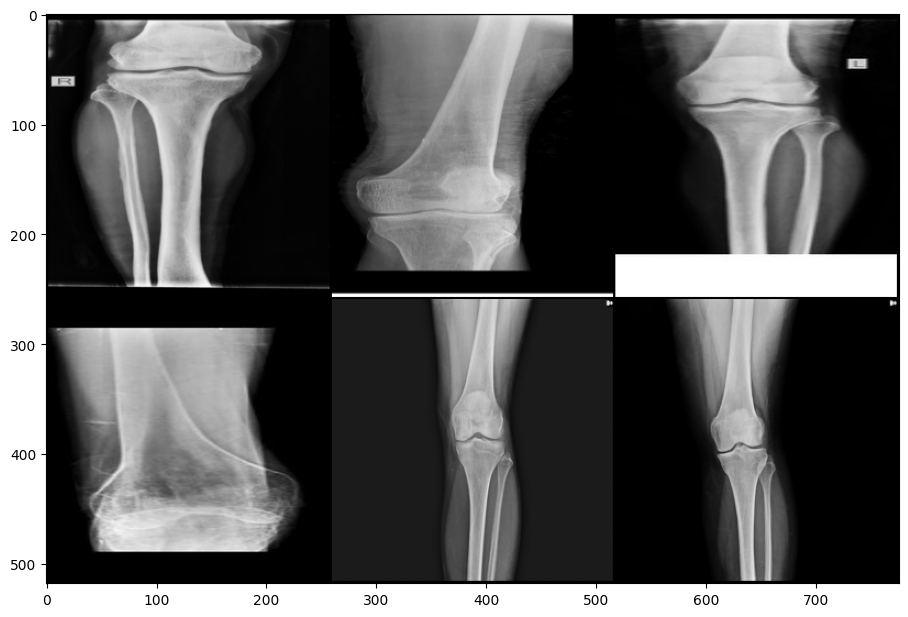

In [13]:
show_transformed_images(train_dataset)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 32, shuffle=False)

In [15]:
def set_device():
    if torch.cuda.is_available():
        dev = 'cuda:0'
    else:
        dev = 'cpu'
    return torch.device(dev)

In [17]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs, checkpoint=True):
    device = set_device()

    epoch_acc_list = []
    best_acc = 0

    for epoch in range(n_epochs):
        print(f'Epoch number {epoch + 1}')
        model.train() # Set train mode
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            # Reset optimizer parameters to 0
            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward() # Back propagate to calculate weight gradient

            optimizer.step() # Update Weights
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print('     - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f' 
              % (running_correct, total, epoch_acc, epoch_loss))

        test_dataset_acc = evaluate_model_on_test_set(model, test_loader)
    
        epoch_acc_list.append(test_dataset_acc)

        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            if checkpoint:
                save_checkpoint(model, epoch, optimizer, best_acc)
        
        cutoff = False
        if cutoff:
            if len(epoch_acc_list) >= 3:
                if epoch_acc_list[-1] == epoch_acc_list[-2] == epoch_acc_list[-3] and epoch_acc_list[-1] > 0:
                    print('Finished')
                    return best_acc, epoch_acc_list
    print('Finished')
    return best_acc, epoch_acc_list

In [18]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch+1,
        'model': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'description': 'Efficientnet Optimised Model'
    }

    torch.save(state, 'model_best_checkpoint.pth.tar')

In [19]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    epoch_acc = 100.0* predicted_correctly_on_epoch / total

    print('     - Testing dataset. Got %d out of %d images correctly (%.3f%%)' 
          % (predicted_correctly_on_epoch, total, epoch_acc))
    
    return epoch_acc

In [20]:

efficientnet_model = models.efficientnet_b0(pretrained=False)
#num_ftrs = efficientnet_model.fc.in_features
num_classes = 2
efficientnet_model.fc = nn.Linear(1280, num_classes)
device = set_device()
efficientnet_model = efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=0.002, momentum=0.3, weight_decay=0.03)
best_acc, epoch_acc_list = train_nn(efficientnet_model, train_loader, test_loader, criterion, optimizer, 150)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch number 1
     - Training dataset. Got 119 out of 520 images correctly (22.885%). Epoch loss: 6.531
     - Testing dataset. Got 0 out of 224 images correctly (0.000%)
Epoch number 2
     - Training dataset. Got 343 out of 520 images correctly (65.962%). Epoch loss: 5.583
     - Testing dataset. Got 107 out of 224 images correctly (47.768%)
Epoch number 3


KeyboardInterrupt: 

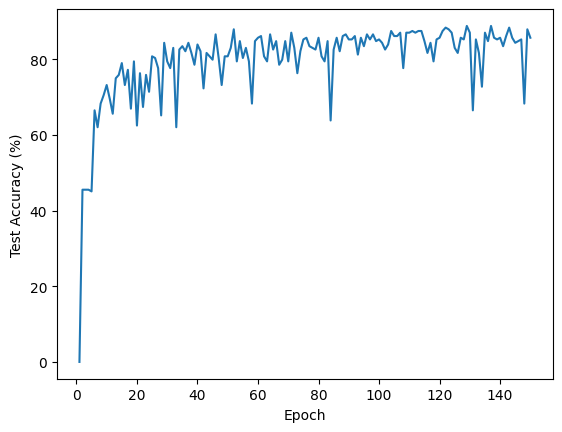

Best Accuracy: 88.839%


In [503]:
plt.plot(list(range(1,len(epoch_acc_list)+1)), epoch_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.show()

print('Best Accuracy: %.3f%%' %(best_acc))

In [32]:
checkpoint = torch.load('model_best_checkpoint.pth.tar', map_location=torch.device('cpu'))
efficientnet_model = models.efficientnet_b0(pretrained=False)
num_classes = 2
efficientnet_model.fc = nn.Linear(1280, num_classes)
efficientnet_model.load_state_dict(checkpoint['model'])
#torch.save(efficientnet_model, 'best_model.pth')

<All keys matched successfully>

Single Image Classifier

In [33]:
import PIL.Image as Image
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)

    output = model(image)
    _, predicted = torch.max(output.data, 1)

    print(f'Prediction: {classes[predicted.item()]}')

In [34]:
classes = ['Normal', 'Osteoporosis']
classify(efficientnet_model, test_transforms, 'normal_example.jpg', classes)
classify(efficientnet_model, test_transforms, 'osteoporosis_example.png', classes)

Prediction: Normal
Prediction: Osteoporosis


Transfer Learning

In [507]:
os.listdir('./transfer dataset/images')

['normal', 'osteoporosis']

In [508]:
transfer_dataset_path = './transfer dataset/images'

In [509]:
transfer_dataset = torchvision.datasets.ImageFolder(root = transfer_dataset_path, transform = test_transforms)


85 59 26
labels:  tensor([1, 0, 1, 0, 1, 0])


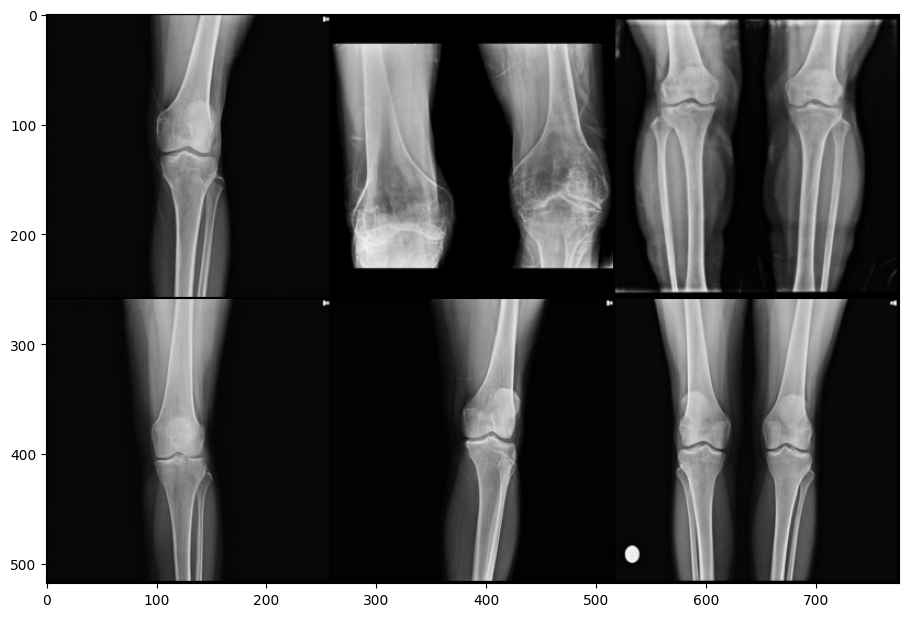

In [510]:
train_size = int(0.7 * len(transfer_dataset))
test_size = len(transfer_dataset) - train_size

print(len(transfer_dataset), train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(transfer_dataset, [train_size, test_size])

train_dataset.dataset.transform = train_transforms
test_dataset.dataset.transform = test_transforms

show_transformed_images(train_dataset)

In [511]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 16, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 16, shuffle=False)

In [512]:
device = set_device()
efficientnet_model = efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(efficientnet_model.parameters(), lr=0.0002, momentum=0.3, weight_decay=0.03)
best_acc, epoch_acc_list = train_nn(efficientnet_model, train_loader, test_loader, criterion, optimizer, 50, False)

Epoch number 1
     - Training dataset. Got 39 out of 59 images correctly (66.102%). Epoch loss: 2.106
     - Testing dataset. Got 17 out of 26 images correctly (65.385%)
Epoch number 2
     - Training dataset. Got 41 out of 59 images correctly (69.492%). Epoch loss: 1.516
     - Testing dataset. Got 18 out of 26 images correctly (69.231%)
Epoch number 3
     - Training dataset. Got 47 out of 59 images correctly (79.661%). Epoch loss: 0.919
     - Testing dataset. Got 19 out of 26 images correctly (73.077%)
Epoch number 4
     - Training dataset. Got 51 out of 59 images correctly (86.441%). Epoch loss: 0.401
     - Testing dataset. Got 19 out of 26 images correctly (73.077%)
Epoch number 5
     - Training dataset. Got 55 out of 59 images correctly (93.220%). Epoch loss: 0.212
     - Testing dataset. Got 20 out of 26 images correctly (76.923%)
Epoch number 6
     - Training dataset. Got 54 out of 59 images correctly (91.525%). Epoch loss: 0.291
     - Testing dataset. Got 19 out of 26 i

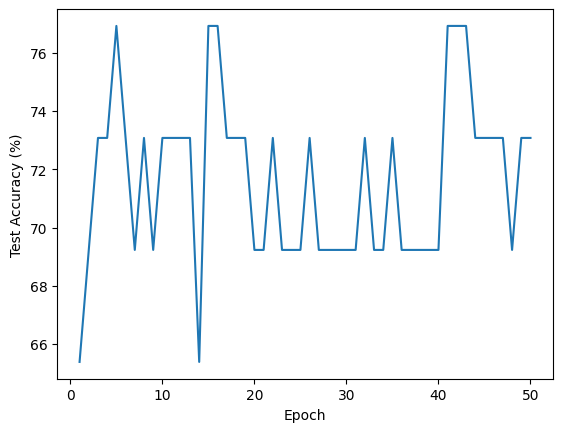

Best Accuracy: 76.923%


In [513]:
plt.plot(list(range(1,len(epoch_acc_list)+1)), epoch_acc_list)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.show()

print('Best Accuracy: %.3f%%' %(best_acc))